In [1]:
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    _c_tr = [r for r in reader]
csv_file.close()
comp_train = []
for c in _c_tr:
    if c['Meas RON'] != 'n.a.':
        comp_train.append(c)

with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    _c_te = [r for r in reader]
csv_file.close()
comp_test = []
for c in _c_te:
    if c['Meas RON'] != 'n.a.':
        comp_test.append(c)

smiles_train = [c[' SMILES'] for c in comp_train]
targets_train = [[float(c['Meas RON'])] for c in comp_train]
smiles_test = [c[' SMILES'] for c in comp_test]
targets_test = [[float(c['Meas RON'])] for c in comp_test]

In [2]:
from graphchem import CompoundOperator

co = CompoundOperator()
train_loss, valid_loss = co.train(
    smiles_train, targets_train, verbose=10,
    valid_size=0.33,
    valid_patience=128,
    batch_size=32,
    epochs=2048,
    random_state=None,
    shuffle=True,
    lr=0.001,
    lr_decay=0.0,
    model_config={
        'n_messages': 2,
        'n_hidden': 1,
        'hidden_dim': 256,
        'dropout': 0.0
    }
)

Epoch: 0 | Train Loss: 6607.518760279605 | Valid Loss: 4745.21875
Epoch: 10 | Train Loss: 1340.942740028783 | Valid Loss: 1333.0101318359375
Epoch: 20 | Train Loss: 846.6866474352385 | Valid Loss: 816.8683471679688
Epoch: 30 | Train Loss: 626.5482511821546 | Valid Loss: 657.2493286132812
Epoch: 40 | Train Loss: 527.3342519659745 | Valid Loss: 501.7611389160156
Epoch: 50 | Train Loss: 425.51877971448397 | Valid Loss: 442.0928039550781
Epoch: 60 | Train Loss: 323.5934155915913 | Valid Loss: 423.1954040527344
Epoch: 70 | Train Loss: 315.11629381681746 | Valid Loss: 370.3392333984375
Epoch: 80 | Train Loss: 327.62131074604235 | Valid Loss: 418.0848083496094
Epoch: 90 | Train Loss: 275.3620403089021 | Valid Loss: 342.55303955078125
Epoch: 100 | Train Loss: 257.8600849352385 | Valid Loss: 268.8370056152344
Epoch: 110 | Train Loss: 287.7515963905736 | Valid Loss: 251.24496459960938
Epoch: 120 | Train Loss: 226.75747552168997 | Valid Loss: 271.9552917480469
Epoch: 130 | Train Loss: 229.7732637

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score

pred_train = co.use(smiles_train)
pred_test = co.use(smiles_test)
print('MAE Train: {}'.format(
    mean_absolute_error(targets_train, pred_train)
))
print('MAE Test: {}'.format(
    mean_absolute_error(targets_test, pred_test)
))
print('R2 Train: {}'.format(
    r2_score(targets_train, pred_train)
))
print('R2 Test: {}'.format(
    r2_score(targets_test, pred_test)
))


MAE Train: 2.5477228837113985
MAE Test: 7.987602308684704
R2 Train: 0.9673885333486131
R2 Test: 0.7438842333811043


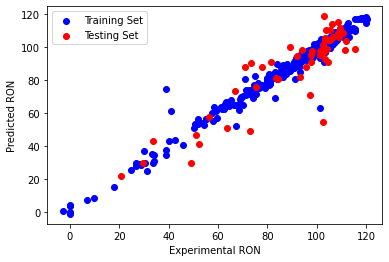

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.scatter(targets_train, pred_train, color='blue', label='Training Set')
plt.scatter(targets_test, pred_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [5]:
co.save_model('model_ron.pt', 'encoder_ron.enc')

In [6]:
co2 = CompoundOperator()
co2.load_model('model_ron.pt', 'encoder_ron.enc')
pred_train = co2.use(smiles_train)
pred_test = co2.use(smiles_test)
print('MAE Train: {}'.format(
    mean_absolute_error(targets_train, pred_train)
))
print('MAE Test: {}'.format(
    mean_absolute_error(targets_test, pred_test)
))
print('R2 Train: {}'.format(
    r2_score(targets_train, pred_train)
))
print('R2 Test: {}'.format(
    r2_score(targets_test, pred_test)
))

MAE Train: 2.5477228837113985
MAE Test: 7.987602308684704
R2 Train: 0.9673885333486131
R2 Test: 0.7438842333811043


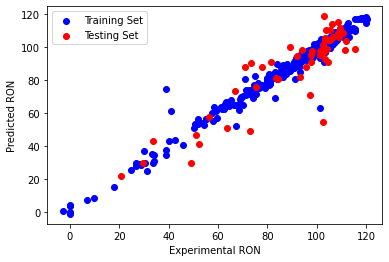

In [7]:
plt.clf()
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.scatter(targets_train, pred_train, color='blue', label='Training Set')
plt.scatter(targets_test, pred_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()